# TEST DATALOADER 2D DISCRETE

In [1]:
import os
os.chdir('/leonardo_scratch/fast/IscrC_DL4EO/github/water-pinns/src')  # Provide the new path here

In [2]:
from operator import itemgetter

import numpy as np
import pandas as pd
import geopandas as gpd
import rioxarray
import fiona

import matplotlib
import matplotlib.pyplot as plt

from rasterio.enums import Resampling
import xarray

from geocube.api.core import make_geocube
from shapely.geometry import box

import json

import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.sampler import SequentialSampler
from torchview import draw_graph

from scipy import signal


from tqdm import tqdm
import time
import wandb
from time import sleep

from models.load_models_2d import *
from loss.load_losses import *
from dataloaders.load_2d_meteo_wtd import DiscreteDataset
from subprocess import Popen

dict_files = {}
with open('/leonardo_scratch/fast/IscrC_DL4EO/github/water-pinns/src/configs/discrete_2D_wtd/test_2D_blocks_normalized.json') as f:
    dict_files = json.load(f)

print(f"Read data.json: {dict_files}")

Read data.json: {'experiment_name': 'pinns_2D_piezo_head_norm_mean', 'comments': 'Testing simple_gradient convolution', 'entity': 'gsartor-unito', 'wandb_dir': '/leonardo_scratch/fast/IscrC_DL4EO/results/discrete_2d/logs', 'data_dir': '/leonardo_work/IscrC_DL4EO/trials/data/', 'wtd_csv_path': '/leonardo_work/IscrC_DL4EO/trials/data/dataset_wtd_roi.csv', 'weather_nc_path': '/leonardo_work/IscrC_DL4EO/trials/data/meteo_bucket_model_snowpack_ROI_1958_2023.nc', 'wtd_shp': '/leonardo_work/IscrC_DL4EO/trials/data/shapefile/underground_wtd_sensor_roi.shp', 'piedmont_shp': '/leonardo_work/IscrC_DL4EO/trials/data/shapefile/piemonte_admin_boundaries.shp', 'dtm_nc': '/leonardo_work/IscrC_DL4EO/trials/data/dtm_ROI.nc', 'save_model_dir': '/leonardo_scratch/fast/IscrC_DL4EO/results/discrete_2d/models', 'timesteps': 180, 'test_split_p': 0.2, 'all_dataset': False, 'max_ds_elems': 4000, 'normalization': True, 'piezo_head': True, 'tensorboard': True, 'dataset': 'wtd_weather_2001_2023', 'dataset_type': '

In [3]:
dtm_roi = rioxarray.open_rasterio(dict_files["dtm_nc"], engine='fiona')
dtm_roi = dtm_roi.rio.write_crs("epsg:4326")
dtm_roi.rio.width

1684

In [4]:
ds = DiscreteDataset(dict_files)

timesteps = dict_files["timesteps"]

Rasterizing wtd dataframe...
Rasterized wtd dataframe.
Creating piezometric head dataset...
Piezometric head dataset created.
shape mean: 295.29437255859375
shape std: 72.11563110351562
Normalization: ON


In [5]:
ds.dtm_roi_downsampled.shape

(1, 57, 84)

In [6]:
ds.wtd_numpy_mean

array(295.29437, dtype=float32)

In [7]:
print(f"Length of the dataset: {ds.__len__()}")

Length of the dataset: 8220


In [8]:
ds.wtd_data_raserized

<xarray.Dataset> Size: 483MB
Dimensions:      (time: 8400, y: 57, x: 84)
Coordinates:
  * y            (y) float64 456B 45.25 45.23 45.22 45.2 ... 44.35 44.33 44.31
  * x            (x) float64 672B 6.628 6.644 6.661 6.678 ... 7.988 8.005 8.022
  * time         (time) datetime64[ns] 67kB 2001-01-01 2001-01-02 ... 2023-12-31
    spatial_ref  int64 8B 0
Data variables:
    wtd          (time, y, x) float64 322MB 295.3 295.3 295.3 ... 295.3 295.3
    wtd_mask     (time, y, x) float32 161MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

In [9]:
# normalization test
ds.weather_xr

<xarray.Dataset> Size: 145MB
Dimensions:      (lon: 12, lat: 9, time: 23864)
Coordinates:
  * lon          (lon) float64 96B 6.688 6.813 6.938 7.063 ... 7.813 7.938 8.063
  * lat          (lat) float64 72B 45.31 45.19 45.06 44.94 ... 44.56 44.44 44.31
  * time         (time) datetime64[ns] 191kB 1958-08-31 ... 2023-12-31
    spatial_ref  int64 8B 0
Data variables:
    prec         (time, lat, lon) float32 10MB -0.3527 -0.3534 ... -0.2029
    tmax         (time, lat, lon) float32 10MB 0.4362 0.5062 ... -0.7063 -0.5348
    tmin         (time, lat, lon) float32 10MB 0.6632 0.6891 ... -0.425 -0.4105
    tmean        (time, lat, lon) float32 10MB 0.547 0.598 ... -0.5892 -0.4867
    prain        (time, lat, lon) float32 10MB -0.3017 -0.3026 ... -0.2918 -0.16
    psnow        (time, lat, lon) float32 10MB -0.2157 -0.2157 ... -0.1528
    et_0         (time, lat, lon) float64 21MB 0.2014 0.2787 ... -1.001 -0.9348
    r_a          (time, lat, lon) float64 21MB 0.4765 0.4765 ... -1.369 -1.369
    snowpack     (time, lat, lon) float64 21MB -0.3515 -0.3515 ... -0.3511
    snowmelt     (time, lat, lon) float64 21MB -0.3119 -0.3119 ... -0.3119

In [10]:
ds.wtd_numpy.shape

(2, 8400, 57, 84)

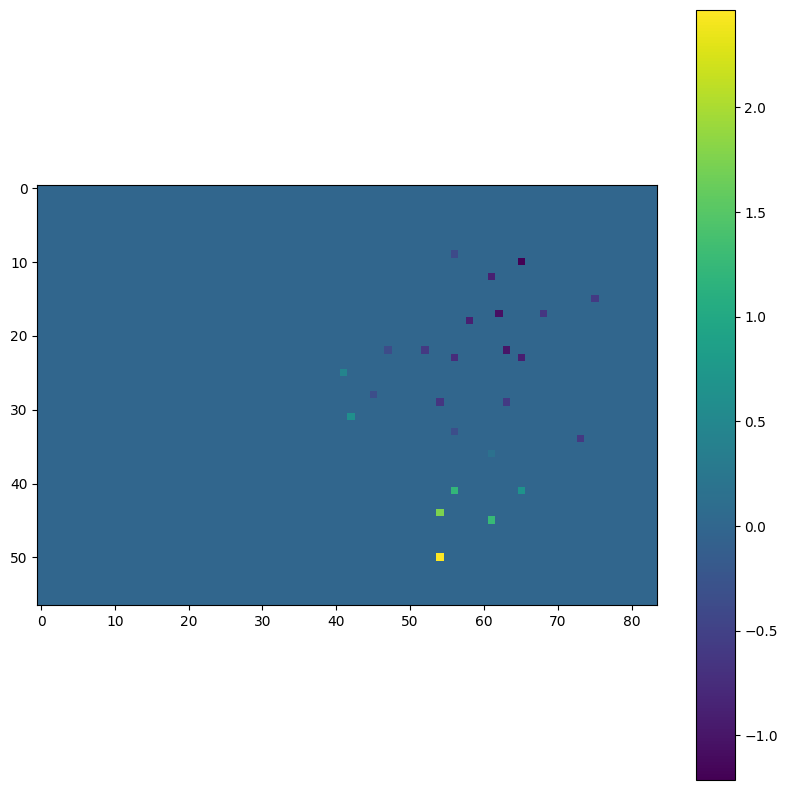

In [11]:
plt.figure(figsize = (10,10))
plt.imshow(ds.wtd_numpy[0,-10,:,:])
plt.colorbar()

In [12]:
x,y,z = ds[-1]
print(f"Sizes: {x.shape} - {y.shape} - {z.shape}")

Sizes: torch.Size([2, 57, 84]) - torch.Size([10, 180, 9, 12]) - torch.Size([2, 180, 57, 84])


In [13]:
z.dtype

torch.float32

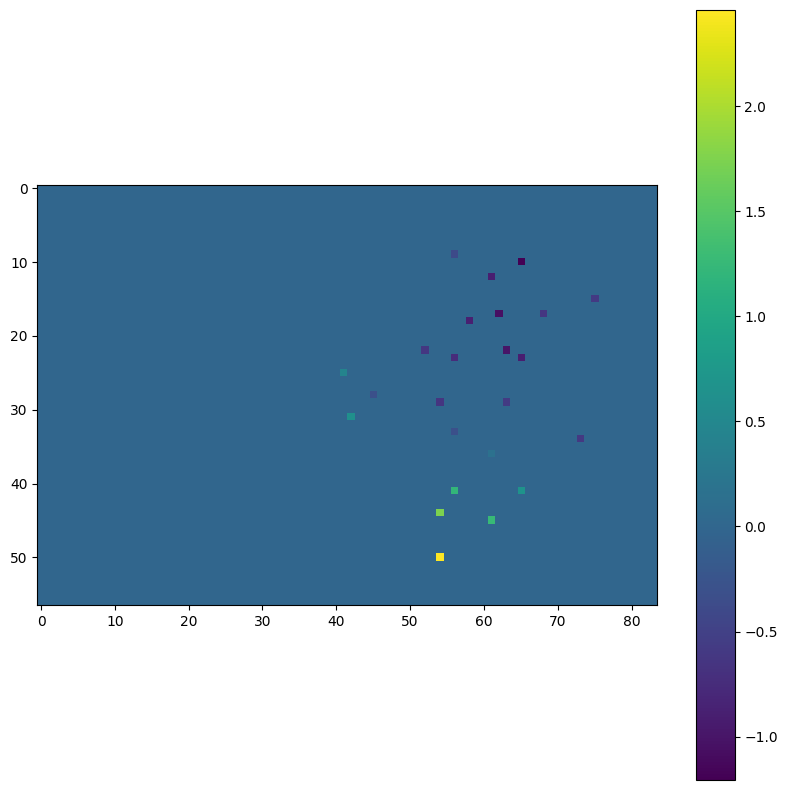

In [14]:
plt.figure(figsize = (10,10))
plt.imshow(x[0,:,:])
plt.colorbar()

/scratch_local/ipykernel_3799540/3072944551.py:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow( (x[0,:,:] * ds.wtd_numpy_std) + ds.wtd_numpy_mean)


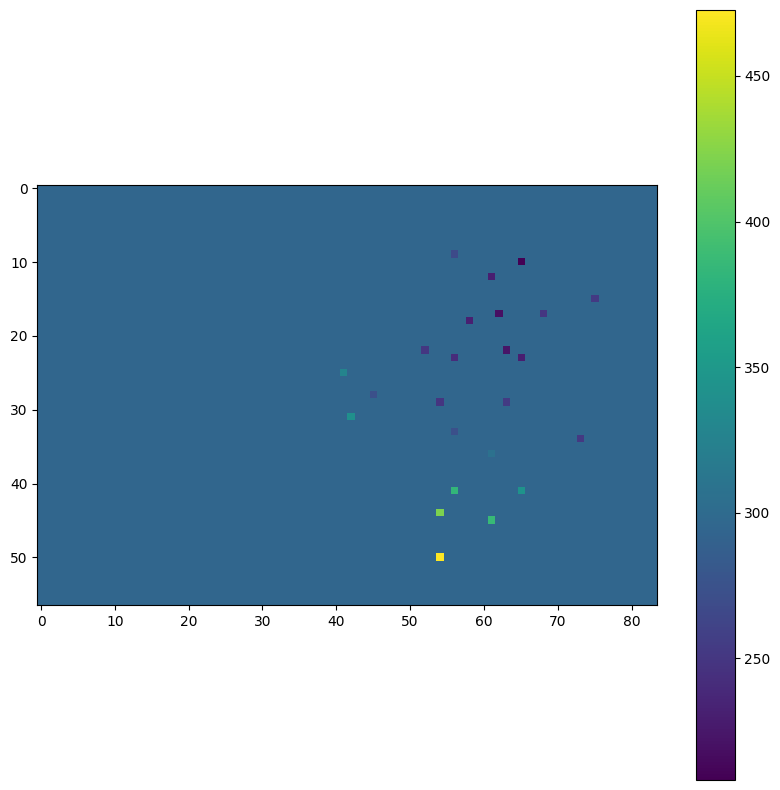

In [15]:
plt.figure(figsize = (10,10))
plt.imshow( (x[0,:,:] * ds.wtd_numpy_std) + ds.wtd_numpy_mean)
plt.colorbar()

In [16]:
x[0,:,:]

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [17]:
ds.dtm_roi_downsampled

<xarray.DataArray '__xarray_dataarray_variable__' (band: 1, y: 57, x: 84)> Size: 19kB
array([[[2695.4011 , 2499.1802 , 2586.5447 , ...,  195.3594 ,
          203.47043,  198.96461],
        [2322.5295 , 2262.4502 , 2304.6958 , ...,  184.70383,
          189.28033,  189.90178],
        [2082.2268 , 1886.0662 , 1840.8513 , ...,  184.88594,
          177.85524,  174.6214 ],
        ...,
        [1544.2092 , 1805.2839 , 1881.0594 , ...,  576.4552 ,
          615.05426,  670.6768 ],
        [1887.1738 , 2127.5986 , 2195.0024 , ...,  676.5523 ,
          745.30304,  780.784  ],
        [1730.4307 , 1736.7605 , 1778.5178 , ...,  662.97205,
          801.55804,  806.8966 ]]], dtype=float32)
Coordinates:
  * x            (x) float64 672B 6.635 6.651 6.668 6.685 ... 7.988 8.005 8.021
  * y            (y) float64 456B 45.26 45.24 45.22 45.21 ... 44.35 44.34 44.32
  * band         (band) int64 8B 1
    spatial_ref  int64 8B 0
Attributes:
    NETCDF_DIM_EXTRA:  {band}
    AREA_OR_POINT:     Area
    scale_factor:      1.0
    add_offset:        0.0
    NETCDF_DIM_band:   1
    _FillValue:        nan

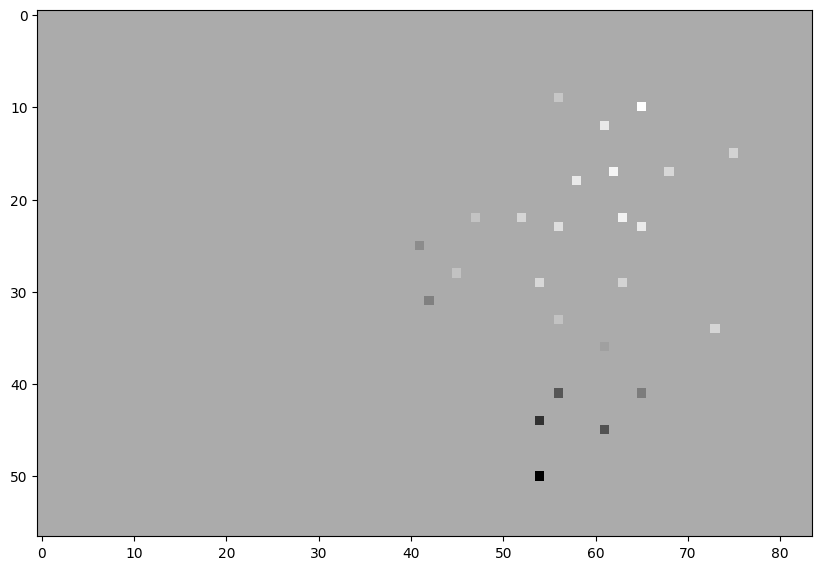

In [18]:
plt.figure(figsize = (10,10))
plt.imshow(ds.wtd_data_raserized["wtd"][-1].values, cmap="binary")

In [19]:
ds.dtm_roi_downsampled[0].shape

(57, 84)

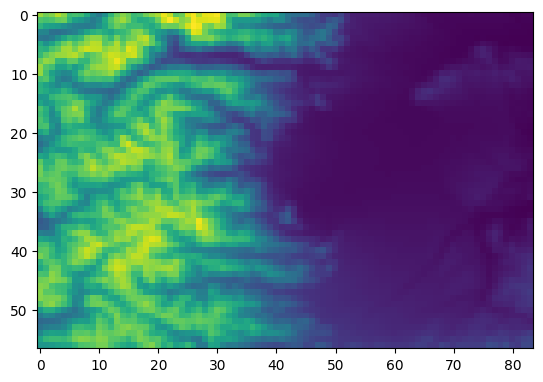

In [20]:
plt.imshow(ds.dtm_roi_downsampled[-1].values)

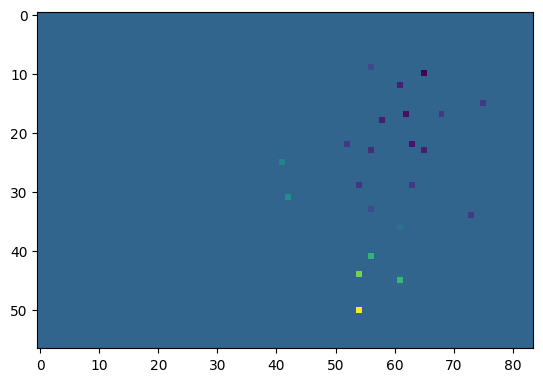

In [21]:
plt.imshow(ds.wtd_data_raserized["wtd"][-90])

In [22]:
input_mask_p = 0.1
output_mask_p = 0.1

nonzero_idxs = np.nonzero(x[:,:,1])
input_mask_m = np.random.uniform(0,1,len(nonzero_idxs)) > input_mask_p
x[nonzero_idxs[:,0],nonzero_idxs[:,1],0] * input_mask_m

/scratch_local/ipykernel_3799540/1532092383.py:6: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  x[nonzero_idxs[:,0],nonzero_idxs[:,1],0] * input_mask_m


tensor([-4.0947, -4.0947, -4.0947, -4.0947, -4.0947, -4.0947, -4.0947, -4.0947,
        -4.0947, -4.0947, -4.0947, -4.0947, -0.0000, -0.0000, -4.0947, -4.0947,
        -4.0947, -4.0947, -4.0947, -4.0947, -4.0947, -4.0947, -4.0947, -0.0000,
        -0.0000, -4.0947, -4.0947, -4.0947, -4.0947, -4.0947, -4.0947, -0.0000,
        -4.0947, -4.0947, -4.0947, -4.0947, -0.0000, -0.0000, -4.0947, -4.0947,
        -4.0947, -4.0947, -4.0947, -4.0947, -4.0947, -4.0947, -4.0947, -4.0947,
        -4.0947, -0.0000, -4.0947, -4.0947, -4.0947, -4.0947, -4.0947, -4.0947,
        -4.0947])

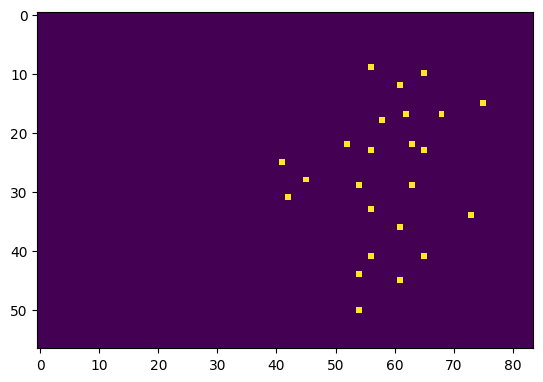

In [23]:
plt.imshow(x[1,:,:])

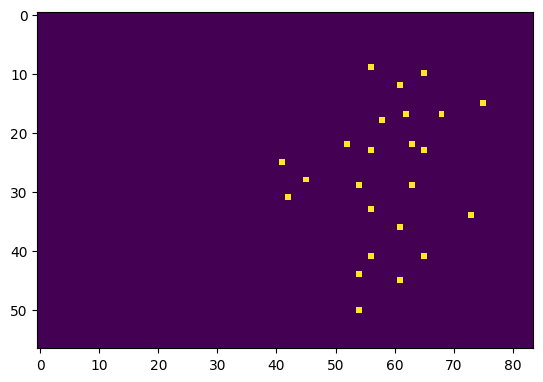

In [24]:
plt.imshow(z[-1,0,:,:])

In [25]:
ds.wtd_data_raserized["wtd"].shape

(8400, 57, 84)

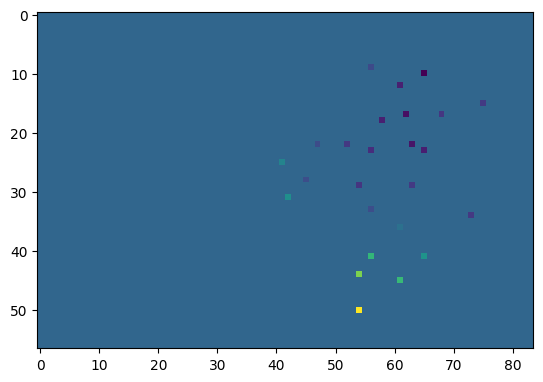

In [26]:
plt.imshow(ds.wtd_data_raserized["wtd"][-1,:,:])

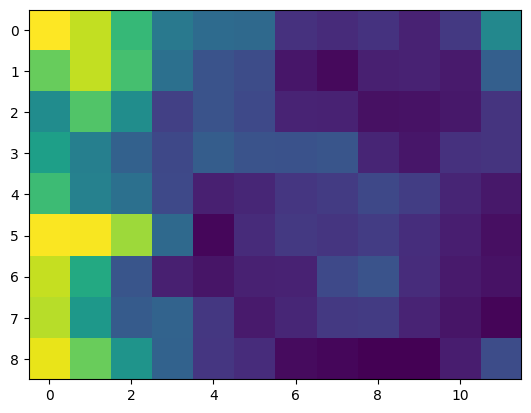

In [27]:
plt.imshow(ds.weather_xr["prec"][-1])

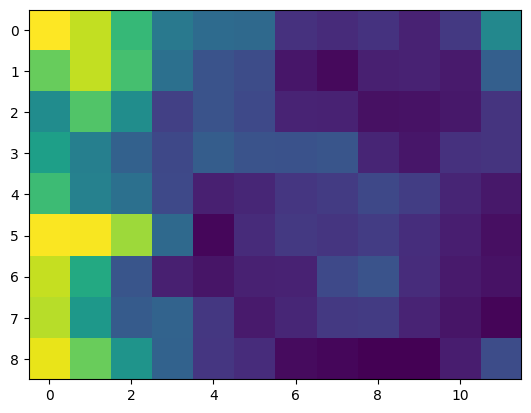

In [28]:
plt.imshow(y[0,-1,:,:])

# TEST DATALOADER

In [29]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

In [30]:
# model = Discrete2DConcat16(timesteps).to(device)
model = Discrete2DSum(timesteps).to(device)

print("Total number of trainable parameters: ", sum(p.numel() for p in model.parameters() if p.requires_grad))

Total number of trainable parameters:  75193


In [31]:
batch_size = dict_files["batch_size"]
max_epochs = dict_files["epochs"]

test_split_p = dict_files["test_split_p"]
train_split_p = 1 - test_split_p

max_ds_elems = ds.__len__()
if not dict_files["all_dataset"]:
    max_ds_elems = dict_files["max_ds_elems"]

train_idx = int(max_ds_elems*train_split_p)
test_idx = int(max_ds_elems*test_split_p)

print(f"Traing size: {train_idx}, Test size: {test_idx}")

train_idxs, test_idxs = np.arange(train_idx), np.arange(train_idx, train_idx + test_idx)

train_sampler = SequentialSampler(train_idxs)
test_sampler = SequentialSampler(test_idxs)

train_loader = torch.utils.data.DataLoader(dataset=ds,
                                            batch_size=2,
                                            sampler=train_sampler)

test_loader = torch.utils.data.DataLoader(dataset=ds,
                                            batch_size=2,
                                            sampler=test_sampler)

Traing size: 3200, Test size: 800


In [32]:
###### BETA ######

input_mask_p = 0.2
output_mask_p = 0.1

def apply_mask(x):
    # TODO: changed dimensions
    nonzero_idxs = np.nonzero(x[:,:,:,1])
    input_mask_m = np.random.uniform(0,1,len(nonzero_idxs)) > input_mask_p
    x[nonzero_idxs[:,0],nonzero_idxs[:,1],nonzero_idxs[:,2],0] = x[nonzero_idxs[:,0],nonzero_idxs[:,1],nonzero_idxs[:,2],0] * input_mask_m
    x[nonzero_idxs[:,0],nonzero_idxs[:,1],nonzero_idxs[:,2],1] = x[nonzero_idxs[:,0],nonzero_idxs[:,1],nonzero_idxs[:,2],1] * input_mask_m

###### BETA ######

In [33]:
###### BETA ######

def loss_masked_v1(y_hat,y):
    print(y_hat.shape)
    print(y.shape)
    # predict = y[:,0,:,:,:].to(device)
    predict = torch.unsqueeze(y[:,0,:,:,:], dim=1).to(device)
    target = y_hat.to(device)
    mask = y[:,1,:,:,:].bool().to(device)
    print(predict.shape)
    print(target.shape)
    print(torch.sum(mask))
    out = torch.sum((torch.masked_select(predict, mask) - torch.masked_select(target, mask))**2.0)  / torch.sum(mask)
    return out

###### BETA ######

In [34]:
model_file_path = f"{dict_files['save_model_dir']}/"

torch.Size([1, 2, 180, 57, 84])


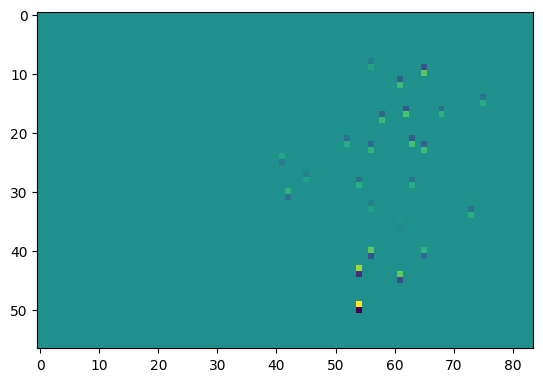

In [35]:
o = torch.unsqueeze(z, dim=0)
print(o.size())
o = ConvLat(o)
plt.imshow(o[0,0,0,:,:])

In [36]:
dtm = torch.from_numpy(ds.dtm_roi_downsampled.values)
wtd_mean = ds.wtd_numpy_mean
wtd_std = ds.wtd_numpy_std

In [37]:
wtd_mean

array(295.29437, dtype=float32)

In [38]:
x, y, z = ds[0]

In [ ]:
model_name = "model_name"
model_graph = draw_graph(model, input_size=((x.shape, y.shape)), device=device)
model_graph.visual_graph.render(format='png', filename = model_name, directory= f"{model_file_path}/")
model_arch = wandb.Image(f"{model_file_path}/{model_name}.png", caption="model's architecture")

RuntimeError: Failed to run torchgraph see error message

In [38]:
from tqdm import tqdm
import time

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

X = None
X_masked = None
Y = None

model.train()
start_time = time.time()

for i in range(max_epochs):
    with tqdm(train_loader, unit="batch") as tepoch:
            for batch_idx, (init_wtd, weather, pred_wtds) in enumerate(tepoch):
                tepoch.set_description(f"Epoch {i}")

                X = (init_wtd.to(device), weather.to(device))
                Y = model(X)
                # loss = pde_grad_loss_darcy(Y)
                loss = loss_positive_height(Y,wtd_mean,wtd_std)
                print(loss)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                
                
end_time = time.time()

Epoch 0:   0%|          | 0/3288 [00:06<?, ?batch/s]


RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

In [6]:
x1,y1,z1 = ds[0]
print(f"Sizes: {x1.shape} - {y1.shape} - {z1.shape}")

Sizes: torch.Size([2, 114, 168]) - torch.Size([10, 180, 9, 12]) - torch.Size([2, 180, 114, 168])


In [7]:
model = Discrete2DConcat16()
model.load_state_dict(torch.load("/leonardo_scratch/fast/IscrC_DL4EO/results/discrete_2d/models/model_20250107_160639.pt", weights_only=True, map_location=torch.device('cpu')))
model.eval()

Discrete2DMidConcatNN(
  (m_conv_1): ConvBlock(
    (block): Sequential(
      (0): Conv3d(2, 8, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=same)
      (1): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv3d(8, 16, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=same)
      (4): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): Conv3d(16, 32, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=same)
      (7): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU()
      (9): Conv3d(32, 16, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=same)
      (10): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): ReLU()
      (12): MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2), padding=0, dilation=1, ceil_mode=False)
    )
  )
  (m_avg_pool_2): AdaptiveMaxPool3d(output_size=(None, 7

In [10]:
X = (torch.unsqueeze(x1, dim=0).to(device), torch.unsqueeze(y1, dim=0).to(device))
Y = (model(X).detach().numpy() * wtd_std) + wtd_mean
print(Y)
print(Y.shape)

[[[[[276.81177 269.48227 273.92978 ... 288.8791  289.95544 277.22256]
    [282.84045 250.27701 244.69957 ... 267.2672  267.5023  256.39362]
    [284.438   254.64232 252.66333 ... 270.0745  272.8791  246.26035]
    ...
    [285.99115 255.06044 241.28645 ... 258.01605 256.75793 242.12039]
    [289.302   240.6755  226.68597 ... 247.73738 248.96072 222.98914]
    [318.3728  284.79224 282.3746  ... 288.60107 285.20413 266.41653]]

   [[276.82675 269.5044  273.97733 ... 288.8694  289.95587 277.24512]
    [282.84784 250.26971 244.78877 ... 267.2177  267.4726  256.3427 ]
    [284.46896 254.63185 252.74309 ... 270.01675 272.92    246.19563]
    ...
    [286.0694  255.54556 240.95619 ... 253.73    257.5562  240.34302]
    [289.4205  240.95883 226.36407 ... 248.2311  250.61755 224.48485]
    [318.35626 284.88754 282.26257 ... 287.75977 284.76938 265.4463 ]]

   [[276.82938 269.52884 274.0053  ... 288.8776  289.94604 277.21994]
    [282.86313 250.29878 244.85815 ... 267.29675 267.5077  256.42572]


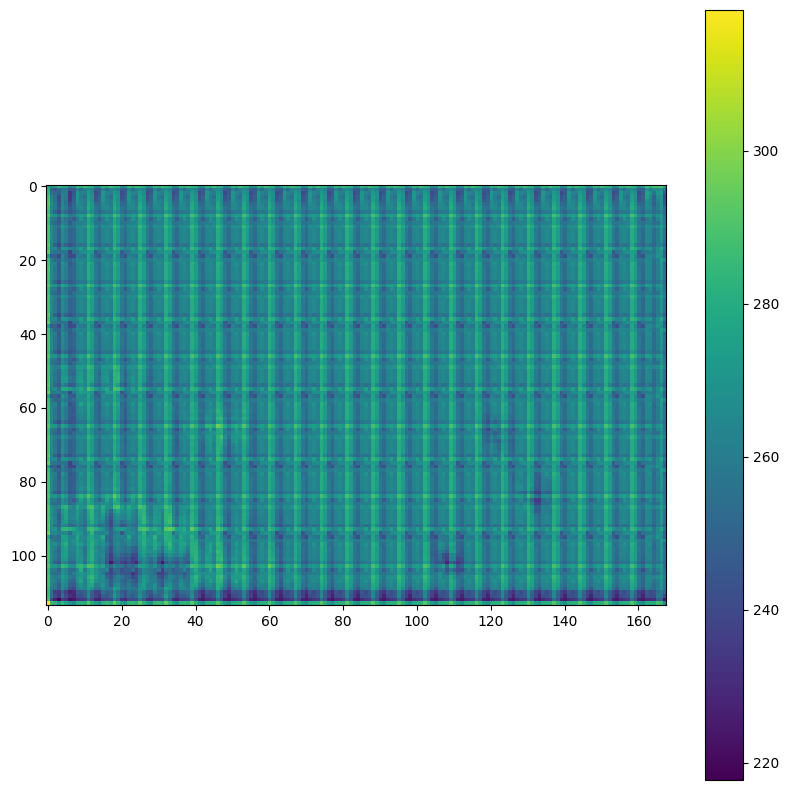

In [11]:
with torch.no_grad():
    plt.figure(figsize = (10,10))
    plt.imshow(Y[0,0,0,:,:])
    plt.colorbar()

In [12]:
wtd_mean

np.float32(14.567584)

In [39]:
z1[0,0,:,:].max()
ds.wtd_numpy_std

np.float32(12.838369)

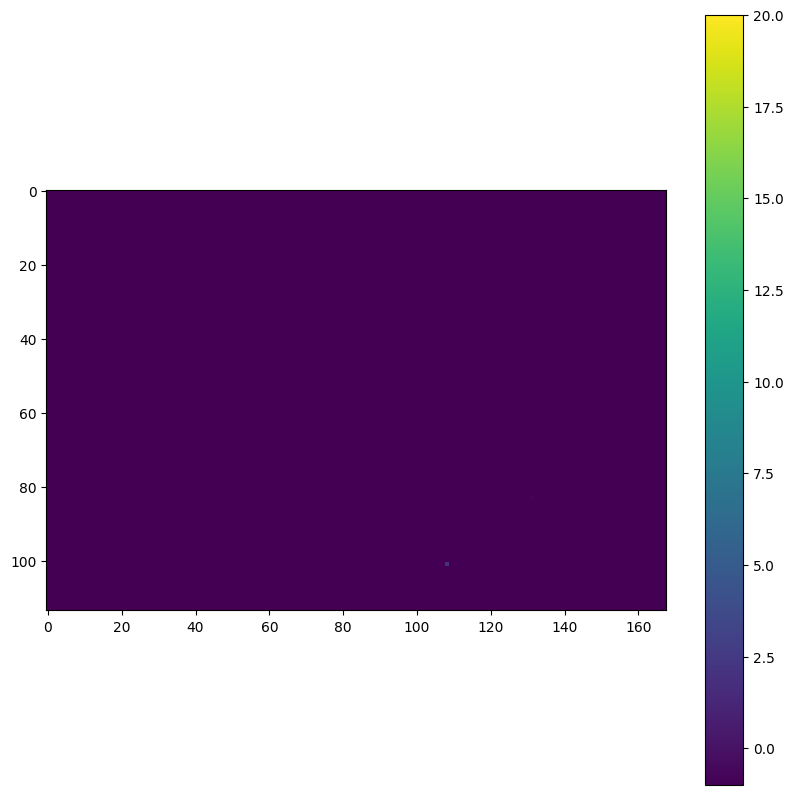

In [40]:
plt.figure(figsize = (10,10))
plt.imshow(z1[0,0,:,:],  vmax=20)
plt.colorbar()